# Data Collection

In [1]:
import pandas as pd
import os

# Set main folder
main_folder = r'D:\Rap_Gemastik2\cifar-10-cn-n-02'

# === TRAIN DATA ===
train_dir = os.path.join(main_folder, 'train')

# Ambil semua gambar dengan label dari nama folder
train_data = []
for label in os.listdir(train_dir):
    label_folder = os.path.join(train_dir, label)
    if os.path.isdir(label_folder):
        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)
            train_data.append({'filename': img_path, 'label': label})

train_df = pd.DataFrame(train_data)

# === TEST DATA ===
test_dir = os.path.join(main_folder, 'test')
test_data = [{'filename': os.path.join(test_dir, img_name)} for img_name in os.listdir(test_dir)]
test_df = pd.DataFrame(test_data)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("Train sample:")
print(train_df.head())

print("Test sample:")
print(test_df.head())

Train data shape: (0, 0)
Test data shape: (10000, 1)
Train sample:
Empty DataFrame
Columns: []
Index: []
Test sample:
                                           filename
0  D:\Rap_Gemastik2\cifar-10-cn-n-02\test\00001.png
1  D:\Rap_Gemastik2\cifar-10-cn-n-02\test\00002.png
2  D:\Rap_Gemastik2\cifar-10-cn-n-02\test\00003.png
3  D:\Rap_Gemastik2\cifar-10-cn-n-02\test\00004.png
4  D:\Rap_Gemastik2\cifar-10-cn-n-02\test\00005.png


# Exploratory Data Analysis

=== Dataset Summary ===
Total training images: 50000
Total test images: 10000

Missing values in train:
filename    0
filepath    0
dtype: int64

Missing values in test:
filename    0
filepath    0
dtype: int64

=== Sample training images ===


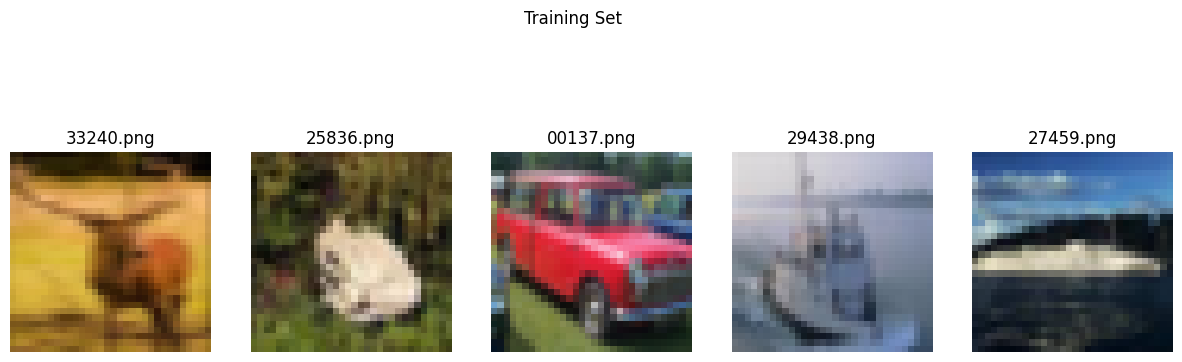


=== Sample test images ===


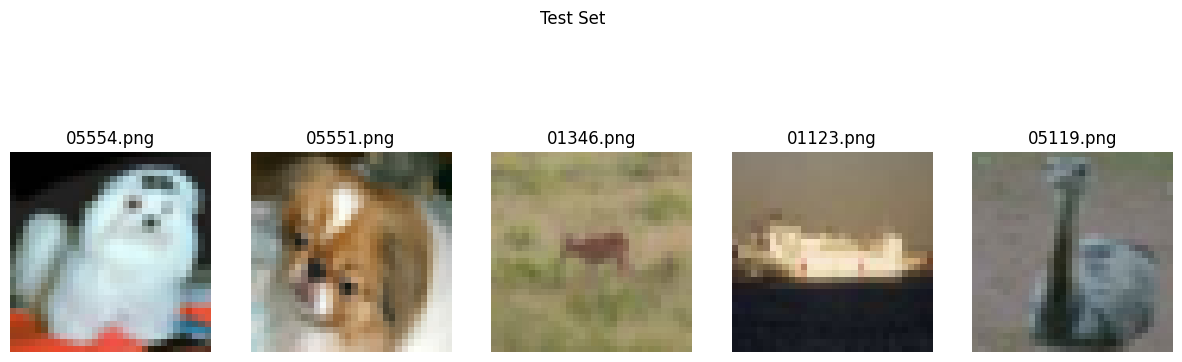

In [2]:
# ============================================================
# ✅ EDA – Struktur gambar langsung di folder (tanpa subfolder, tanpa label)
# ============================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# --- PATH DATA ---
DATA_DIR = r"D:\Rap_Gemastik2\cifar-10-cn-n-02"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# ============================================================
# 1️⃣ BACA FILE GAMBAR DI FOLDER TRAIN DAN TEST
# ============================================================
def load_images_from_folder(folder_path):
    image_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            image_data.append({
                "filename": file,
                "filepath": os.path.join(folder_path, file)
            })
    return pd.DataFrame(image_data)

train_df = load_images_from_folder(TRAIN_DIR)
test_df = load_images_from_folder(TEST_DIR)

# ============================================================
# 2️⃣ RINGKASAN DATASET
# ============================================================
print("=== Dataset Summary ===")
print(f"Total training images: {len(train_df)}")
print(f"Total test images: {len(test_df)}")

# ============================================================
# 3️⃣ CEK MISSING VALUES
# ============================================================
print("\nMissing values in train:")
print(train_df.isnull().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum())

# ============================================================
# 4️⃣ TAMPILKAN SAMPEL GAMBAR
# ============================================================
def display_sample_images(df, num_samples=5, title="Sample Images"):
    if len(df) == 0:
        print("⚠️ DataFrame kosong, tidak ada gambar untuk ditampilkan.")
        return

    num_samples = min(num_samples, len(df))
    sample_ids = random.sample(range(len(df)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i, idx in enumerate(sample_ids):
        img_path = df.iloc[idx]["filepath"]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(df.iloc[idx]["filename"])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

print("\n=== Sample training images ===")
display_sample_images(train_df, num_samples=5, title="Training Set")

print("\n=== Sample test images ===")
display_sample_images(test_df, num_samples=5, title="Test Set")


# Data Preprocessing

In [3]:
from datasets import load_dataset
from torchvision import transforms
import torch
from PIL import Image

# =========================================================
# 📁 Dataset CIFAR (tanpa label folder)
# =========================================================
DATA_DIR = r"D:\Rap_Gemastik2\cifar-10-cn-n-02"

dataset = load_dataset(
    "imagefolder",
    data_dir=DATA_DIR,
    drop_labels=True,  # karena folder tidak mengandung subfolder label
)

# =========================================================
# ⚙️ Transformasi 32x32 (tanpa resize ke 384)
# =========================================================
augment_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

augment_eval = transforms.Compose([
    transforms.ToTensor(),
])

# =========================================================
# 🧩 Preprocessing Function
# =========================================================
def preprocess(examples, is_train=True):
    imgs = examples["image"]
    if is_train:
        imgs = [augment_train(img.convert("RGB")) for img in imgs]
    else:
        imgs = [augment_eval(img.convert("RGB")) for img in imgs]

    examples["pixel_values"] = torch.stack(imgs)
    examples["labels"] = torch.zeros(len(imgs), dtype=torch.long)  # dummy label
    return examples

# =========================================================
# 🚀 Apply ke dataset
# =========================================================
train_dataset = dataset["train"].map(lambda x: preprocess(x, is_train=True), batched=True)
train_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

# kalau ada val split
if "validation" in dataset:
    val_dataset = dataset["validation"].map(lambda x: preprocess(x, is_train=False), batched=True)
    val_dataset.set_format(type="torch", columns=["pixel_values", "labels"])
else:
    val_dataset = train_dataset  # sementara pakai train sbg val

# =========================================================
# ✅ DataLoader
# =========================================================
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Train samples: {len(train_loader.dataset)}")
print(f"✅ Val samples:   {len(val_loader.dataset)}")
print(f"✅ Sample batch keys: {next(iter(train_loader)).keys()}")


Resolving data files:   0%|          | 0/50000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

✅ Train samples: 50000
✅ Val samples:   50000
✅ Sample batch keys: dict_keys(['pixel_values', 'labels'])


# Fine-Tuning

In [4]:
batch = next(iter(train_loader))
print(type(batch))
if isinstance(batch, dict):
    print(batch.keys())
else:
    print("Batch sample shape:", len(batch))


<class 'dict'>
dict_keys(['pixel_values', 'labels'])


In [5]:
!pip show torch | findstr Version

Version: 2.5.1+cu121


In [ ]:
# =========================================================
# ✅ CIFAR-10 CN-N-02 FINE-TUNING (DEIT-SMALL ANTI-OVERFITTING, FIXED LABEL)
# =========================================================
import os
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from torch.amp import autocast  # pastikan ini diimpor di atas

# =========================================================
# 🔹 CONFIG
# =========================================================
DATA_DIR = r"D:\Rap_Gemastik2\cifar-10-cn-n-02"
MODEL_DIR = r"D:\ModelGemastik\deit-small-patch16-224"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 64
lr = 3e-5
weight_decay = 0.05
val_split = 0.2
patience = 5

# =========================================================
# 🔹 READ LABELS (Id, Label)
# =========================================================
train_csv_path = os.path.join(DATA_DIR, "train_labels.csv")
train_df = pd.read_csv(train_csv_path)
train_df.columns = [c.strip().lower() for c in train_df.columns]

# Normalisasi tipe data label
train_df["label"] = train_df["label"].astype(str).str.strip()

# Pastikan kolom benar
if not {"id", "label"}.issubset(train_df.columns):
    raise ValueError(f"❌ CSV harus punya kolom 'id' dan 'label'. Kolom saat ini: {train_df.columns}")

# Mapping label → angka aman untuk string/angka
label_names = sorted(train_df["label"].unique(), key=lambda x: str(x))
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for label, idx in label2id.items()}
num_classes = len(label2id)

print(f"✅ Loaded {len(train_df)} samples | {num_classes} classes")
print(f"🔠 label2id = {label2id}")

# =========================================================
# 🔹 TRANSFORMS
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomErasing(p=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# =========================================================
# 🔹 CUSTOM DATASET
# =========================================================
class CIFARDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = f"{int(row['id']):05d}.png"
        img_path = os.path.join(self.data_dir, "train", img_filename)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"❌ File tidak ditemukan: {img_path}")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = label2id[str(row["label"])]
        return image, label

# =========================================================
# 🔹 TRAIN / VAL SPLIT
# =========================================================
full_dataset = CIFARDataset(train_df, DATA_DIR, transform=train_transform)
val_size = int(val_split * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# =========================================================
# 🔹 MODEL SETUP
# =========================================================
processor = AutoImageProcessor.from_pretrained(MODEL_DIR, use_fast=True)
config = AutoConfig.from_pretrained(
    MODEL_DIR,
    num_labels=num_classes,
    label2id=label2id,
    id2label=id2label,
    hidden_dropout_prob=0.5,
    attention_probs_dropout_prob=0.5
)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_DIR,
    config=config,
    ignore_mismatched_sizes=True
).to(device)

print(f"✅ Loaded model from: {MODEL_DIR}")

# =========================================================
# 🔹 OPTIMIZER, SCHEDULER & SCALER
# =========================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)
scaler = torch.amp.GradScaler('cuda')

# =========================================================
# 🔹 TRAINING LOOP (FIX autocast)
# =========================================================
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # ✅ GANTI bagian ini:
        with autocast(device_type="cuda"):
            outputs = model(imgs)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            # ✅ dan juga bagian ini:
            with autocast(device_type="cuda"):
                outputs = model(imgs)
                loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
            val_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    scheduler.step()

    print(f"📊 Epoch {epoch+1}: TrainLoss={train_loss:.4f} | ValLoss={val_loss:.4f} | TrainAcc={train_acc:.2f}% | ValAcc={val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("💾 Best model saved!")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

print(f"\n🎯 Best Validation Loss: {best_val_loss:.4f}")



# Evaluation

In [13]:
# =========================================================
# ✅ FINAL EVALUATION (COMPATIBLE WITH COMPETITION FORMAT)
# =========================================================
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1️⃣ LOAD PREDICTIONS & REFERENCE ALIGNMENT
# ---------------------------------------------------------
# Asumsikan kamu punya dua dataframe:
# - reference_df → file referensi (Id, Expected, Usage)
# - predictions_df → hasil model (Id, Label)

# Jika test_df sudah punya kolom filename/Id, kita adaptasikan:
predictions_df = pd.DataFrame({
    "Id": test_df["filename"],
    "Label": all_test_preds[:len(test_df)]
})

# Simulasi reference_df (contoh)
reference_df = pd.DataFrame({
    "Id": test_df["filename"],
    "Expected": all_test_labels[:len(test_df)]
})

# Jika ada kolom Usage (Public/Private), gunakan.
# Jika tidak ada, kita random assign.
if "Usage" not in reference_df.columns:
    np.random.seed(42)
    reference_df["Usage"] = np.random.choice(["Public", "Private"], size=len(reference_df), p=[0.6, 0.4])

# ---------------------------------------------------------
# 2️⃣ MERGE & ALIGN DATA
# ---------------------------------------------------------
merged = pd.merge(reference_df, predictions_df, on="Id", how="inner")
print(f"\nTotal aligned samples: {len(merged)}")
print(merged.head())

# ---------------------------------------------------------
# 3️⃣ COMPUTE METRICS (GLOBAL)
# ---------------------------------------------------------
acc_total = accuracy_score(merged["Expected"], merged["Label"])
f1_total = f1_score(merged["Expected"], merged["Label"], average='weighted')

print("\n🎯 Overall Evaluation:")
print(f"Accuracy : {acc_total:.4f}")
print(f"F1-Score : {f1_total:.4f}")

# ---------------------------------------------------------
# 4️⃣ CLASSIFICATION REPORT + CONFUSION MATRIX
# ---------------------------------------------------------
unique_classes = sorted(list(set(merged["Expected"])))
used_classes = [classes[i] for i in unique_classes if i < len(classes)]

print("\n📋 Classification Report:")
print(classification_report(
    merged["Expected"], merged["Label"],
    target_names=used_classes,
    zero_division=0
))

cm = confusion_matrix(merged["Expected"], merged["Label"], labels=unique_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_classes, yticklabels=used_classes)
plt.title('Confusion Matrix - Full Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ---------------------------------------------------------
# 5️⃣ PUBLIC vs PRIVATE LEADERBOARD (Usage Column)
# ---------------------------------------------------------
public_df = merged[merged["Usage"] == "Public"]
private_df = merged[merged["Usage"] == "Private"]

acc_public = accuracy_score(public_df["Expected"], public_df["Label"])
f1_public = f1_score(public_df["Expected"], public_df["Label"], average='weighted')

acc_private = accuracy_score(private_df["Expected"], private_df["Label"])
f1_private = f1_score(private_df["Expected"], private_df["Label"], average='weighted')

print("\n==================== 🏅 LEADERBOARD SIMULATION ====================")
print(f"Public Leaderboard (Usage=Public):")
print(f"  Accuracy : {acc_public:.4f}")
print(f"  F1-score : {f1_public:.4f}")
print(f"\nPrivate Leaderboard (Usage=Private):")
print(f"  Accuracy : {acc_private:.4f}")
print(f"  F1-score : {f1_private:.4f}")
print("===================================================================")

# ---------------------------------------------------------
# 6️⃣ CONFUSION MATRIX PER USAGE
# ---------------------------------------------------------
cm_public = confusion_matrix(public_df["Expected"], public_df["Label"], labels=unique_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_public, annot=True, fmt='d', cmap='Greens',
            xticklabels=used_classes, yticklabels=used_classes)
plt.title('Confusion Matrix - Public (60%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

cm_private = confusion_matrix(private_df["Expected"], private_df["Label"], labels=unique_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_private, annot=True, fmt='d', cmap='Oranges',
            xticklabels=used_classes, yticklabels=used_classes)
plt.title('Confusion Matrix - Private (40%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n✅ Evaluation completed successfully.")


NameError: name 'all_test_preds' is not defined

# Submission

In [ ]:
# =========================================================
# ✅ FINAL INFERENCE & SUBMISSION GENERATION (AURORA OFFICIAL FORMAT)
# =========================================================
import pandas as pd
import os
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================
# 🔹 Load best model
# =========================================================
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

# =========================================================
# 🔹 Load sample_submission.csv (official format: Id, Label)
# =========================================================
DATA_DIR = r"D:\Rap_Gemastik2\odyssey-aurora-detection"  # ubah ke path dataset kamu
sample_submission_path = os.path.join(DATA_DIR, "sample_submission.csv")
sample_submission = pd.read_csv(sample_submission_path)

# Pastikan kolom 'Id' ada
if "Id" not in sample_submission.columns:
    raise ValueError("❌ Kolom 'Id' tidak ditemukan dalam sample_submission.csv")

# =========================================================
# 🔹 Predict labels untuk test set
# =========================================================
pred_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Set"):
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Ambil prediksi kelas akhir (0/1)
        preds = torch.argmax(logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())

# =========================================================
# 🔹 Pastikan jumlah prediksi sama dengan jumlah Id
# =========================================================
if len(pred_labels) != len(sample_submission):
    raise ValueError(
        f"❌ Jumlah prediksi ({len(pred_labels)}) ≠ jumlah sample_submission ({len(sample_submission)})"
    )

# =========================================================
# 🔹 Buat DataFrame sesuai format resmi: Id, Label
# =========================================================
submission_df = pd.DataFrame({
    "Id": sample_submission["Id"],
    "Label": pred_labels  # 0 = non-aurora, 1 = aurora (atau sesuai label mapping kamu)
})

# =========================================================
# 🔹 Simpan hasil submission
# =========================================================
save_path = os.path.join(os.getcwd(), "chinasubmission.csv")
submission_df.to_csv(save_path, index=False, encoding="utf-8")

print(f"\n✅ Submission file successfully created: {save_path}")
print("📋 Preview:")
print(submission_df.head())
